In [1]:
#Copyright 2020 Vraj Shah, Arun Kumar
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

from Load_Predictions import *
from downstream_models import *
from Featurize import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
testdf = pd.read_csv('Benchmark-Labeled-Data/data_train.csv')
test_metadata = pd.read_csv('../RawCSV/Metadata/meta_data.csv')

print(len(testdf),len(test_metadata))
test_merged = pd.merge(testdf,test_metadata,on='Record_id')

y_true = test_merged.y_act.values.tolist()

7936 4233


In [3]:
test_merged

,Record_id,Attribute_name,y_act,total_vals,num_nans,%_nans,num_of_dist_val,%_dist_val,mean,std_dev,...,mean_char_count,stdev_char_count,mean_whitespace_count,stdev_whitespace_count,mean_delim_count,stdev_delim_count,is_list,is_long_sentence,name,link
0,33,Area,categorical,21477,0,0.000000,174,0.810169,0.000000,0.000000,...,10.0,4.816638,0.4,0.800000,0.4,0.800000,False,False,FAO.csv,https://www.kaggle.com/dorbicycle/world-foodfe...
1,33,Area Code,categorical,21477,0,0.000000,174,0.810169,125.449411,72.866452,...,1.0,0.000000,0.0,0.000000,0.0,0.000000,False,False,FAO.csv,https://www.kaggle.com/dorbicycle/world-foodfe...
2,33,Element,categorical,21477,0,0.000000,2,0.009312,0.000000,0.000000,...,4.0,0.000000,0.0,0.000000,0.0,0.000000,False,False,FAO.csv,https://www.kaggle.com/dorbicycle/world-foodfe...
3,33,Element Code,categorical,21477,0,0.000000,2,0.009312,5211.687154,146.816661,...,4.0,0.000000,0.0,0.000000,0.0,0.000000,False,False,FAO.csv,https://www.kaggle.com/dorbicycle/world-foodfe...
4,33,Item,categorical,21477,0,0.000000,115,0.535457,0.000000,0.000000,...,19.6,2.244994,2.0,0.000000,2.0,0.000000,False,False,FAO.csv,https://www.kaggle.com/dorbicycle/world-foodfe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,4180,%,embedded-number,94,39,41.489362,41,43.617021,0.000000,0.000000,...,4.6,0.800000,0.0,0.000000,0.0,0.000000,False,False,Veal & Calf History.csv,https://www.kaggle.com/usda/the-national-summa...
7932,4181,date,datetime,366,0,0.000000,366,100.000000,0.000000,0.000000,...,6.0,0.000000,0.0,0.000000,0.0,0.000000,False,False,weather_data_nyc_centralpark_2016(1).csv,https://www.kaggle.com/mathijs/weather-data-in...
7933,4185,notes,sentence,2023,5,0.247158,311,15.373208,0.000000,0.000000,...,32.8,21.113029,4.8,3.600000,4.8,3.600000,False,False,klavern.csv,https://www.kaggle.com/jboysen/mapping-the-kkk
7934,4201,Purposes,sentence,21,1,4.761905,20,95.238095,0.000000,0.000000,...,52.2,29.294368,7.4,4.223742,7.4,4.223742,False,False,Schemes of india.csv,https://www.kaggle.com/robinreni/inda-basic-da...


In [4]:
dict_label_true = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

y_true = [dict_label_true[str(i)] for i in y_true]

In [5]:
table_column_names = ['Record_id', 'Attribute_name', 'y_act', 'total_vals', 'num_nans',
           '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val',
           'max_val', 'has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
           'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
           'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
           'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
           'is_list', 'is_long_sentence', 
           'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5',
           'sample_6', 'sample_7', 'sample_8', 'sample_9', 'sample_10',]

In [6]:
sample_size_list = [1,2,3,4,5,10]
rand_seed = 99

results = []
df_data = pd.DataFrame()

final_results = {}

for iteration in range(3):
    
    for sample_size in sample_size_list:

        start = time.time()

        prv_csv_name, csv_name = '', ''
        drop_samples = 10-sample_size
        if sample_size!=10:
            table_names = table_column_names[:-drop_samples]
        else:
            table_names = table_column_names

        exception_indices = []
        error_count = 0

        for index, row in test_merged.iterrows():  

            if index%10==0:
                print(index)

            col = row['Attribute_name']
            prv_csv_name = csv_name
            csv_name = '../RawCSV/RawCSVFiles/' + row['name']

            if prv_csv_name != csv_name:
                df = pd.read_csv(csv_name,encoding='latin1')

            try:
                df_sample = df[[col]].sample(n=sample_size, random_state=rand_seed)

                dataFeaturized = FeaturizeFile(df_sample)
                dataFeaturized1 = ProcessStats(dataFeaturized)
                dataFeaturized2 = FeatureExtraction(dataFeaturized,dataFeaturized1,0)
                dataFeaturized2 = dataFeaturized2.fillna(0)

                dataFeaturized2.insert(0, 'y_act', row['y_act'])
                dataFeaturized2.insert(0, 'Attribute_name', row['Attribute_name'])
                dataFeaturized2.insert(0, 'Record_id', row['Record_id'])
                labeled_row = dataFeaturized2.iloc[:, :28]

                for sample_value in range(len(df_sample[col].values)):
                    col_name = f"sample_{sample_value+1}"
                    labeled_row.insert(12, col_name, df_sample[col].values[sample_value])
                df_data = df_data.append(labeled_row)

            except:
                original_row = pd.DataFrame()
                for col_name in table_names:
                    if (col_name in row.index):
                        original_row[col_name] = [row[col_name]]

                df_data = df_data.append(original_row)
                print('Error')
                error_count += 1

        end = time.time()
        runtime = end-start

        if sample_size in final_results:
            final_results[sample_size].append(runtime)
        else:
            final_results[sample_size] = [runtime]
            
            
#     df_data = df_data[table_names]
#     print(df_data.columns)
#     df_data.to_csv(f"Sampled-Benchmark-Labeled-Data/{sample_size}_sample_data_train.csv", index=False)


0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Error
880
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
7110
7120
7130
7140
7150
7160
7170
7180
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
7660
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
Error
Error
Error
Error
Error
Error
6660
Error
Error
Error
Error
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
Error
Error
6780
Error
Error
Error
Error
Error
Error
6790
Error
Error
Error
Error
Error
6800
6810
6820
6830
6840
6850
Error
6860
6870
Error
Error
Error
6880
Error
Error
Error
Error
Error
6890
6900
6910
Error
Error
Error
6920
Error
6930
Error
Error
Error
Error
Error
Error
Error
Error
Error
6940
6950
Error
Error
Error
6960
Error
Error
6970
Error
Error
Error
Error
Error
Error
Error
Error
Error
6980
Error
Error
6990
7000
7010
7020
7030
Error
Error
Error
Error
7040
7050
Error
7060
7070
7080
7090
7100
Error
7110
7120
Error
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
Error
7230
Error
Error
Error
7240
7250
7260
7270
Error
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
Error
7370
Error
7380
7390
7400
7410
7420
Error
Error
74

C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
Error
880
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
7110
7120
7130
7140
7150
7160
7170
7180
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
7660
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
Error
Error
Error
Error
Error
Error
6660
Error
Error
Error
Error
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
Error
Error
6780
Error
Error
Error
Error
Error
Error
6790
Error
Error
Error
Error
Error
6800
6810
6820
6830
6840
6850
Error
6860
6870
Error
Error
Error
6880
Error
Error
Error
Error
Error
6890
6900
6910
Error
Error
Error
6920
Error
6930
Error
Error
Error
Error
Error
Error
Error
Error
Error
6940
6950
Error
Error
Error
6960
Error
Error
6970
Error
Error
Error
Error
Error
Error
Error
Error
Error
6980
Error
Error
6990
7000
7010
7020
7030
Error
Error
Error
Error
7040
7050
Error
7060
7070
7080
7090
7100
Error
7110
7120
Error
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
Error
7230
Error
Error
Error
7240
7250
7260
7270
Error
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
Error
7370
Error
7380
7390
7400
7410
7420
Error
Error
74

C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
Error
880
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
7110
7120
7130
7140
7150
7160
7170
7180
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
7660
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
7470
7480
7490
7500
7510
7520
7530
7540
7550
7560
7570
7580
7590
7600
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
7240
7250
7260
7270
7280
7290
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
6660
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
6780
6790
6800
6810
6820
6830
6840
6850
6860
6870
6880
6890
6900
6910
6920
6930
6940
6950
6960
6970
6980
6990
7000
7010
7020
7030
7040
7050
7060
7070
7080
7090
7100
Error
7110
7120
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
7230
Error
Error
Error
7240
7250
7260
7270
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
7370
7380
7390
7400
7410
7420
Error
Error
7430
7440
7450


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error
0
10
20
30
40
50
60
70
80
90
100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


110
120
130


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
Error
840
Error
Error
Error
850
Error
Error
Error
Error
860
870
Error
Error
Error
Error
880
Error
Error
890
900
910
920
930
940
950
960


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


970
980
990
1000
1010


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,19,137,138,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,10,19,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1670
1680
1690
1700
1710
1720
1730
1740
Error
Error
1750
1760


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2760
2770
2780
2790
2800
2810
2820


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2830
2840
2850
2860
2870
2880
2890


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2900
2910
2920
2930
2940
2950


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2960
2970
2980
2990
3000
3010
3020


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
Error
3170
Error
3180
Error
Error
Error
3190
3200
Error
3210
Error
3220
3230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3240
3250
3260


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,10,18,19,20,21,23,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3270
3280
3290


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
Error
Error
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
Error
3650
Error
Error
3660
3670
Error
3680
Error
Error
Error
Error
3690
Error
Error
Error
3700
3710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3870
3880
3890
3900
3910
3920


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3930
3940


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


3950
3960
3970
3980
3990
4000
4010
4020
4030


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4040


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4050
4060
4070
4080
4090
4100


C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690
4700
4710


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4720
4730
4740
4750
4760
4770
4780


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4790
4800
4810
4820
4830
4840
4850
4860
4870
4880
4890
4900
4910
4920
4930
4940
4950
4960
4970
4980
4990
5000
5010
5020
5030
5040
5050
5060
5070


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5080
5090
5100
5110
5120
5130
5140
5150
5160
5170
5180
5190
5200
5210
5220
5230


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (403,405,832,833,841,844,857,915,916,928,929,941,942,954,955,957,958,967,968,970,971,980,981,993,994,996,997,1006,1007,1009,1010,1022,1023,1035,1036,1048,1049,1071,1072,1084,1085,1087,1088,1097,1098,1100,1101,1110,1111,1113,1114,1126,1127,1139,1140,1149,1150,1152,1153,1162,1163,1165,1166,1178,1179,1191,1192,1204,1205,1217,1218,1227,1228,1230,1231,1240,1241,1243,1244,1256,1257,1269,1270,1282,1283,1295,1296,1306,1308,1309,1319,1321,1322,1335,1347,1348,1373,1374,1386,1387,1399,1400,1412,1413,1451,1452,1453,1480,1481,1482,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1654,1669,1704,1732,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1746,1747,1748,1749,1750,1751,1752,1753) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5240
5250
5260
5270
5280
5290
5300
5310
5320
5330
5340
5350
5360
5370
5380
5390
5400
5410
5420
5430
5440
5450
5460
5470
5480
5490
5500
5510
5520
5530
5540
5550
5560
5570
5580
5590
5600
5610
5620
5630
5640
5650
5660
5670
5680
5690
5700
5710
5720
5730
5740
5750
5760
5770
5780
5790
5800
5810
5820
5830
5840
5850
5860
5870
5880
5890
5900
5910
5920
5930
5940
5950
5960
5970
5980
5990
6000
6010
6020
6030
6040
6050
6060
6070
6080
6090
6100


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6110


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (40,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6120
6130
6140
6150
6160
6170
6180
6190
6200
6210
6220
6230
6240
6250
6260
6270
6280
6290
6300
6310
6320


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (41,142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6330
6340
6350
6360
6370
6380
6390
6400
6410
6420
6430
6440
6450
6460
6470
6480
6490
6500
6510
6520


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6530
6540


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,6,7,11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6550
6560
6570
6580
6590
Error
6600
6610
6620
6630
Error
6640
6650
Error
Error
Error
Error
Error
Error
6660
Error
Error
Error
Error
6670
6680
6690
6700
6710
6720
6730
6740
6750
6760
6770
Error
Error
Error
Error
Error
Error
6780
Error
Error
Error
Error
Error
Error
6790
Error
Error
Error
Error
Error
6800
6810
6820
6830
6840
6850
Error
6860
6870
Error
Error
Error
6880
Error
Error
Error
Error
Error
6890
6900
6910
Error
Error
Error
6920
Error
6930
Error
Error
Error
Error
Error
Error
Error
Error
Error
6940
6950
Error
Error
Error
6960
Error
Error
6970
Error
Error
Error
Error
Error
Error
Error
Error
Error
6980
Error
Error
6990
7000
7010
7020
7030
Error
Error
Error
Error
7040
7050
Error
7060
7070
7080
7090
7100
Error
7110
7120
Error
7130
7140
7150
7160
7170
7180
Error
Error
Error
7190
7200
7210
7220
Error
Error
7230
Error
Error
Error
7240
7250
7260
7270
Error
7280
Error
Error
7290
Error
Error
Error
Error
7300
7310
7320
7330
7340
7350
7360
Error
7370
Error
7380
7390
7400
7410
7420
Error
Error
74

C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname AST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7460
Error
Error
Error
Error
Error
Error
7470
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7480
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7490
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7500
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7510
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7520
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7530
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7540
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7550
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7560
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7570
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7580
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7590
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7600
Error
Error
Error
Error
Error
Error
7610


C:\Users\Andrew\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


7620
7630
7640
7650
Error
7660
Error
7670
7680
7690
7700
7710
7720
7730
7740
7750
7760
7770
7780
7790
7800
Error
Error
Error
Error
Error
7810
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7820
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7830
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7840
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7850
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7860
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7870
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7880
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
7890
Error
Error
Error
Error
Error
Error
Error
7900
Error
Error
Error
7910
Error
Error
Error
Error
7920
Error
Error
Error
Error
Error
Error
Error
Error
7930
Error


In [7]:
final_results

{1: [407.16187715530396, 697.897590637207, 1058.6506505012512],
 2: [430.99070262908936, 744.3097987174988, 1105.8568141460419],
 3: [463.1622350215912, 789.4639782905579, 1154.6177830696106],
 4: [500.70360350608826, 847.8556454181671, 1214.438000679016],
 5: [547.2238595485687, 907.7180104255676, 1284.1943967342377],
 10: [657.9031100273132, 1001.3365223407745, 1358.7152931690216]}

In [8]:
mean_runtimes = pd.DataFrame()

for sample_size, runtime in final_results.items():
    print(np.mean(runtime))
    mean_runtimes[sample_size] = [np.mean(runtime)]

721.2367060979208
760.3857718308767
802.4146654605865
854.3324165344238
913.0454222361246
1005.9849751790365


In [13]:
mean_runtimes.index=['Sample Size']
mean_runtimes = mean_runtimes.transpose()
mean_runtimes

,Sample Size
1,721.236706
2,760.385772
3,802.414665
4,854.332417
5,913.045422
10,1005.984975


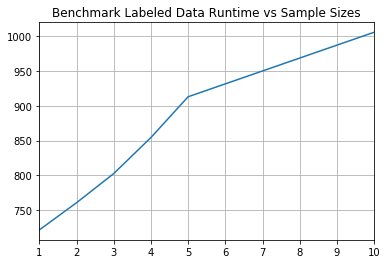

In [16]:
mean_runtimes.plot(title='Benchmark Labeled Data Runtime vs Sample Sizes', legend=False, grid=True, xticks=[1,2,3,4,5,6,7,8,9,10])